In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import highdicom as hd
import pydicom as pd
from pydicom.sr.codedict import codes
import numpy as np
import circle_fit
import skimage.draw
import imageio

In [6]:
# Input file
image_file_base = './data/OAI-9003175-V06-20090723'
image_file_dicom = f'{image_file_base}.dcm'
image_file_points = f'{image_file_dicom}.pts'

# Output file
image_file_segmentation = f'{image_file_base}--segmentation.dcm'

In [7]:
# set to mm/pixel, or None to disable resampling
target_pixel_spacing = None

Image size: (1860, 2316)
Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 210
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Computed Radiography Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.21767.127.0.0.1.1251311760.0.0.1.1
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.5.3
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_353'
(0002, 0016) Source Application Entity Title     AE: 'SYNARC_IMDA'
-------------------------------------------------
(0008, 0000) Group Length                        UL: 896
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Computed Radiography Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3

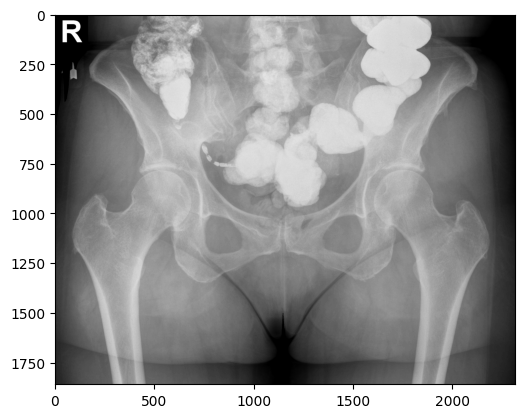

In [8]:
# load data
img = pd.dcmread(image_file_dicom)
plt.imshow(img.pixel_array, cmap='gray')
print(f"Image size: {img.pixel_array.shape}")
print(img)

In [5]:
def load_points(image_file_points):
    """
    Load points from BoneFinder.
    Coordinates are defined in mm.
    """
    points = None

    with open(image_file_points, 'r') as f:
        f.readline()

        n_points = int(f.readline().strip().split(' ')[1])

        assert f.readline().strip() == '{'

        points = [[float(x) for x in f.readline().strip().split(' ')] for _ in range(n_points)]

        assert f.readline().strip() == '}'

    return np.array(points)

points = load_points(image_file_points)
print('Number of points:', len(points))

Number of points: 160


In [6]:
def get_source_pixel_spacing(img):
    """
    Extract pixel spacing (mm/pixel) from the DICOM headers
    """
    pixel_spacing = img.get('PixelSpacing') or img.get('ImagerPixelSpacing')
    assert pixel_spacing is not None, 'No pixel spacing found'
    assert pixel_spacing[0] == pixel_spacing[1], 'Assymetric pixel spacing is untested'
    return pixel_spacing

pixel_spacing = get_source_pixel_spacing(img)
print('Input pixel spacing:', pixel_spacing)

Input pixel spacing: [0.16896, 0.16896]


In [7]:
def resample_to_target_resolution(img, pixel_spacing, target_pixel_spacing):
    """
    Resample image to the required resolution
    """
    _img_pixels = None
    _pixel_spacing = pixel_spacing
    if target_pixel_spacing is None:
        _img_pixels = img.pixel_array
    else:
        _scale_factor = pixel_spacing[0] / target_pixel_spacing
        _img_pixels = skimage.transform.rescale(img.pixel_array, _scale_factor)
        _pixel_spacing = [target_pixel_spacing, target_pixel_spacing]
    
    return _img_pixels, _pixel_spacing

def check_photometric_interpretation(img, img_pixels):
    """
    Are the intensities stored as MONOCHROME2 (white=max, black=min) or as MONOCHROME1 (white=min, black=max)?
    """
    _img_pixels = img_pixels
    _photometric_interpretation = img.get('PhotometricInterpretation')
    if _photometric_interpretation == 'MONOCHROME1':
        print('Photometric interpretation MONOCHROME1: inverting intensities')
        _img_pixels = np.max(img_pixels) - img_pixels
    else:
        assert _photometric_interpretation == 'MONOCHROME2',\
            f'{_photometric_interpretation} not supported'
    return _img_pixels
        
def check_VOILUT_function(img):
    assert img.get('VOILUTFunction', 'LINEAR') == 'LINEAR', \
        'only supporting VOILUTFunction LINEAR'
    
img_pixels, pixel_spacing = resample_to_target_resolution(img, pixel_spacing, target_pixel_spacing)
img_pixels = check_photometric_interpretation(img, img_pixels)
check_VOILUT_function(img)

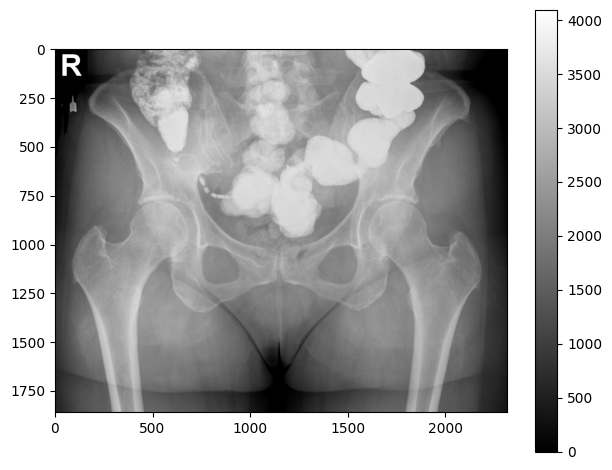

In [8]:
plt.imshow(img_pixels, cmap='gray')
plt.colorbar()
plt.tight_layout()

In [9]:
# define the curves: right first, then left
SIDES = { 'right': 0, 'left': 80 }
CURVES = {
    'proximal femur':     [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34],
    'greater trochanter': [6, 35, 36, 37, 38, 39],
    'posterior wall':     [40, 41, 42, 43, 44],
    'ischium and pubis':  [44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
    'foramen':            [60, 61, 62, 63, 64, 65, 66],
    'acetabular roof':    [67, 68, 69, 70, 71, 72, 73, 74],
}
SUB_CURVES = {
    'femoral head':       [18, 19, 20, 21, 22, 23, 24, 25, 26, 27],
    'sourcil':            [70, 71, 72, 73, 74],
}

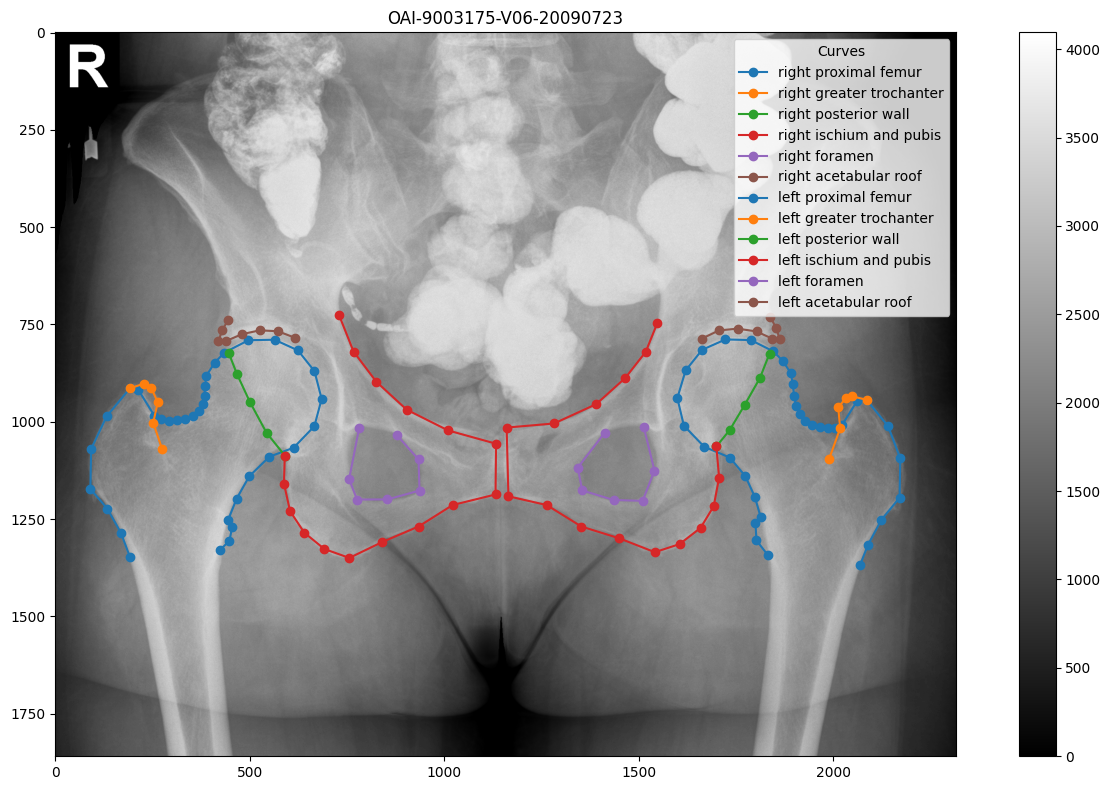

In [10]:
def plot_curves(img, img_pixels, points, pixel_spacing, curves, sides):
    # plot the image with superimposed curves
    plt.figure(figsize=(13, 8))
    plt.imshow(img_pixels, cmap='gray')
    plt.colorbar()

    # plot curves for right and left
    for side, offset in sides.items():
        for idx, (name, curve) in enumerate(curves.items()):
            color = plt.rcParams['axes.prop_cycle'].by_key()['color'][idx]
            plt.plot(*(points[np.array(curve) + offset] / pixel_spacing).transpose(),
                    marker='o', color=color,
                    label=f'{side} {name}',)
    plt.title(image_file_base)
    plt.legend(title='Curves')
    plt.tight_layout()

plot_curves(img, img_pixels, points, pixel_spacing, CURVES, SIDES)

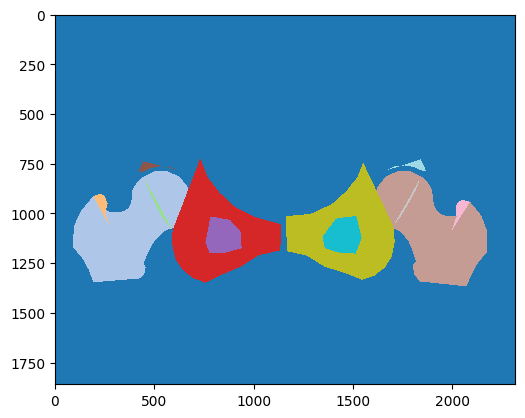

In [11]:
# Convert the polygons to a pixel mask
combined_mask = np.zeros(shape=img_pixels.shape, dtype=np.uint8)

c_idx = 0
for side, offset in SIDES.items():
    for idx, (name, curve) in enumerate(CURVES.items()):
        c_idx += 1
        mask = skimage.draw.polygon2mask(
            img_pixels.shape,
            (points[np.array(curve) + offset] / pixel_spacing)[:, [1, 0]]
        )
        combined_mask[mask] = c_idx

plt.figure()
plt.imshow(combined_mask, cmap='tab20', interpolation='none')

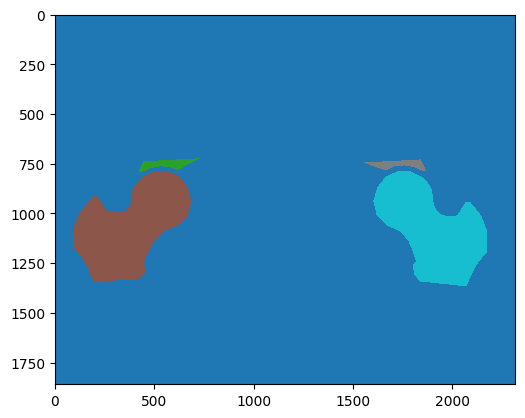

In [12]:
combined_mask = np.zeros(shape=img_pixels.shape, dtype=np.uint8)

mask_region_curves = {
    # topmost point of ischium & pubis curve
    'acetabular roof': CURVES['acetabular roof'] + [59],
    'proximal femur':  CURVES['proximal femur'],
}

c_idx = 0
for side, offset in SIDES.items():
    for idx, (name, curve) in enumerate(mask_region_curves.items()):
        c_idx += 1
        mask = skimage.draw.polygon2mask(
            img_pixels.shape,
            (points[np.array(curve) + offset] / pixel_spacing)[:, [1, 0]]
        )
        combined_mask[mask] = c_idx

plt.figure()
plt.imshow(combined_mask, cmap='tab10', interpolation='none')

In [13]:
# Fit a circle to the circular part of the femoral head, 
# in order to determine the center of the femoral head.
circles = dict()
for side, offset in SIDES.items():
    for name, curve in SUB_CURVES.items():
        xc, yc, r, sigma = circle_fit.taubinSVD(points[np.array(curve) + offset])
        circles[f'{side} {name}'] = { 'xc': xc, 'yc': yc, 'r': r, 'sigma': sigma }

print('Fitted circles:')
for name, circle in circles.items():
    print(f' {name}: {circle}')

Fitted circles:
 right femoral head: {'xc': 89.8668136027152, 'yc': 158.59865913704337, 'r': 25.740560038004595, 'sigma': 0.14427161817732662}
 right sourcil: {'xc': 90.62529084118225, 'yc': 159.616287916161, 'r': 30.379361598391036, 'sigma': 0.12935439978617563}
 left femoral head: {'xc': 295.98068947528253, 'yc': 158.59037704745813, 'r': 25.694637651929142, 'sigma': 0.1970230267268661}
 left sourcil: {'xc': 295.9325650356547, 'yc': 156.87580273699197, 'r': 28.451906966252945, 'sigma': 0.09455521714845337}


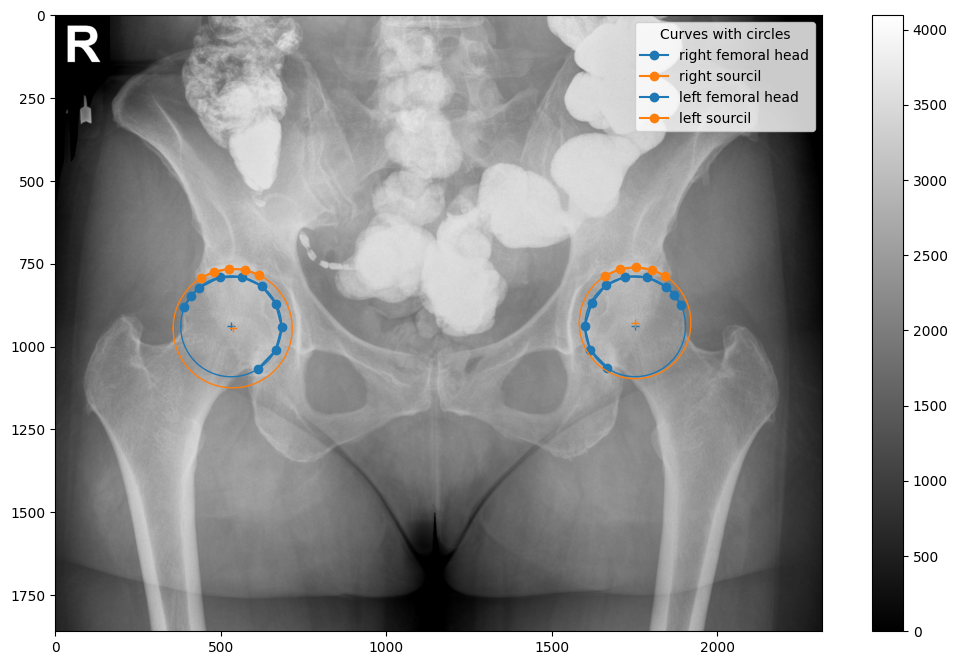

In [14]:
# plot circles 
plt.figure(figsize=(13, 8))
plt.imshow(img_pixels, cmap='gray')
plt.colorbar()

for side, offset in SIDES.items():
    for idx, (name, curve) in enumerate(SUB_CURVES.items()):
        color = plt.rcParams['axes.prop_cycle'].by_key()['color'][idx]
        curve = np.array(curve) + offset
        # points
        plt.plot(points[curve, 0] / pixel_spacing[0],
                 points[curve, 1] / pixel_spacing[1],
                 marker='o', color=color,
                 label=f'{side} {name}',)
        # circle
        circle = circles[f'{side} {name}']
        theta_fit = np.linspace(-np.pi, np.pi, 180)
        x_fit = circle['xc'] + circle['r'] * np.cos(theta_fit)
        y_fit = circle['yc'] + circle['r'] * np.sin(theta_fit)
        plt.plot(x_fit / pixel_spacing[0], y_fit / pixel_spacing[1], color=color, linewidth=1)
        plt.plot(circle['xc'] / pixel_spacing[0],
                 circle['yc'] / pixel_spacing[1],
                 '+', color=color)
plt.legend(title='Curves with circles')

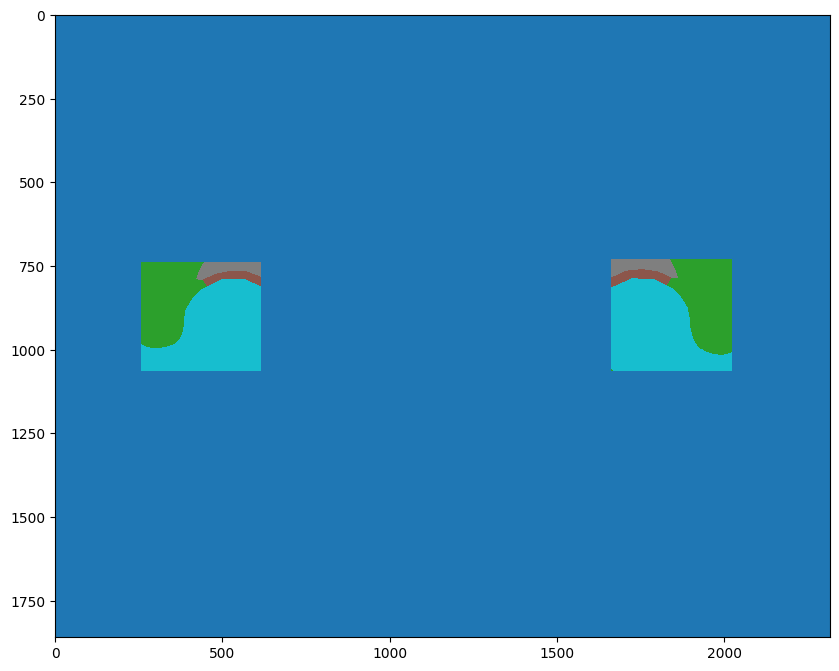

In [15]:
"""
## Joint-space segmentation mask;
    - Create a multi-class segmentation image, with background, acetabulum, femur, and joint space.
    - The segmentation is only defined within a bounding box around the joint space.
"""

combined_mask = np.zeros(shape=img_pixels.shape, dtype=np.uint8)
fg_mask = np.zeros_like(combined_mask, dtype=bool)

LABELS = {
    'ignore': 0,
    'background': 1,
    'acetabulum': 2,
    'femur': 3,
    'joint space': 4,
}

# background label inside the bounding box
combined_mask[:] = LABELS['background']

js_bbox = {}

for side, offset in SIDES.items():
    # define the bounding box of the segmentation region
    js_bbox[side] = bbox = {
        # top: topmost point of acetabulum curve
        'top': points[67 + offset][1],
        # medial: most medial point of the sourcil
        'medial': points[74 + offset][0],
        # lateral:
        'lateral': points[8 + offset][0],
        # bottom: medial bottom of femoral head
        'bottom': points[27 + offset][1],
    }

    # include bbox in foreground/background mask
    fg_mask[skimage.draw.polygon2mask(
        fg_mask.shape,
        np.array([
            [bbox['top'], bbox['lateral']],
            [bbox['bottom'], bbox['lateral']],
            [bbox['bottom'], bbox['medial']],
            [bbox['top'], bbox['medial']],
        ]) / np.array(pixel_spacing)[[1, 0]]
    )] = True

    # from most lateral part of the sourcil to center of femoral head
    circle = circles[f'{side} femoral head']

    # define the regions
    regions = {
        'joint space': np.array([
            # note: this polygon is larger than the joint space,
            # but the excess will be covered by the bone regions
            # - start from most lateral point of the sourcil
            points[70 + offset],
            # - to center of femoral head
            [circle['xc'], circle['yc']],
            # - to medial boundary of bbox
            [bbox['medial'], circle['yc']],
            # - to medial top
            [bbox['medial'], bbox['top']],
            # - to topmost point of acetabulum curve
            points[67 + offset],
        ]),
        'acetabulum': np.array([
            *points[np.array(CURVES['acetabular roof']) + offset],
            [bbox['medial'], bbox['top']],
        ]),
        'femur': np.array([
            *points[np.array(CURVES['proximal femur']) + offset],
        ]),
    }

    # add regions to mask
    for idx, (name, region) in enumerate(regions.items()):
        mask = skimage.draw.polygon2mask(
            combined_mask.shape,
            (region / pixel_spacing)[:, [1, 0]]
        )
        combined_mask[mask] = idx + 2

# set background outside bounding box
combined_mask[~fg_mask] = LABELS['ignore']

plt.figure(figsize=(10, 10))
plt.imshow(combined_mask, cmap='tab10', interpolation='nearest')

In [16]:
if img.pixel_array.shape != img_pixels.shape:
    print('Pixel spacing changed; DICOM-SEG not saved.')
else:
    algorithm = hd.content.AlgorithmIdentificationSequence(
        name='BoneFinder ground truth',
        family=codes.cid7162.ArtificialIntelligence,
        version='1.0',
    )

    segment_descriptions = []
    for label, label_idx in LABELS.items():
        if label_idx > 0:
            segment_descriptions.append(hd.seg.SegmentDescription(
                segment_number=label_idx,
                segment_label=label,
                segmented_property_category=codes.SCT.Bone,
                segmented_property_type=codes.SCT.Bone,
                algorithm_type=hd.seg.SegmentAlgorithmTypeValues.AUTOMATIC,
                algorithm_identification=algorithm,
            ))

    seg_dataset = hd.seg.Segmentation(
        source_images=[img],
        pixel_array=combined_mask,
        segmentation_type=hd.seg.SegmentationTypeValues.FRACTIONAL,
        # BINARY doesn't work in Weavis, but FRACTIONAL is similar and does
        # segmentation_type=hd.seg.SegmentationTypeValues.BINARY,
        segment_descriptions=segment_descriptions,
        series_instance_uid=hd.UID(),
        series_number=2,
        sop_instance_uid=hd.UID(),
        instance_number=1,
        manufacturer='Example',
        manufacturer_model_name='Example',
        software_versions='v1',
        device_serial_number='N/A',
    )
        
    seg_dataset.save_as(image_file_segmentation)

c:\Users\drago\AppData\Local\Programs\Python\Python312\Lib\site-packages\highdicom\valuerep.py:54: UserWarning: The string "OAI9003175" is unlikely to represent the intended person name since it contains only a single component. Construct a person name according to the format in described in https://dicom.nema.org/dicom/2013/output/chtml/part05/sect_6.2.html#sect_6.2.1.2, or, in pydicom 2.2.0 or later, use the pydicom.valuerep.PersonName.from_named_components() method to construct the person name correctly. If a single-component name is really intended, add a trailing caret character to disambiguate the name.
  warnings.warn(
